In [1]:
import pandas as pd
import requests
from nltk.corpus import stopwords
import nltk
import numpy as np
import re
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras import Input
from sklearn.preprocessing import LabelEncoder
import collections
import matplotlib.pyplot as plt

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers



In [2]:
nltk.download('stopwords')
url = "https://raw.githubusercontent.com/ashutoshmakone/Twitter-US-Airline-Sentiment-classification/main/Dataset/Tweets.csv"
df = pd.read_csv(url, sep=',')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kamiljedryczek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 10  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 24  # Maximum number of words in a sequence
GLOVE_DIM = 300  # Number of dimensions of the GloVe word embeddings

In [17]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=2)
    return history


def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=2)
    results = model.evaluate(X_test, y_test)
    
    return results

def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)

In [5]:
# df.head()

In [6]:
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 13176
# Test data samples: 1464


In [8]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [9]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    13176.000000
mean        11.180480
std          4.215493
min          1.000000
25%          8.000000
50%         12.000000
75%         14.000000
max         24.000000
Name: text, dtype: float64

In [10]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [11]:
X_test_seq_trunc[10]


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,  206,   62, 7277,  468,  510,  350,    3,  662,
         30,  190], dtype=int32)

In [12]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

## One Hot embeddings

In [13]:
from sklearn.preprocessing import OneHotEncoder
result_train = []
for seq in X_train_seq_trunc:
    result_train.append(to_categorical(seq, num_classes=NB_WORDS))
    
result_test = []
for seq in X_test_seq_trunc:
    result_test.append(to_categorical(seq, num_classes=NB_WORDS))

In [14]:
X_train_oh = np.array(result_train)
X_test_oh = np.array(result_test)
X_train_oh.shape

(13176, 24, 10000)

In [15]:
oh_model = models.Sequential()
oh_model.add(Input(shape=(MAX_LEN, NB_WORDS,)))
oh_model.add(layers.Flatten())
oh_model.add(layers.Dense(3, activation='softmax'))
oh_model.summary()

2022-07-03 15:22:51.349457: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-03 15:22:51.349846: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 240000)            0         
                                                                 
 dense (Dense)               (None, 3)                 720003    
                                                                 
Total params: 720,003
Trainable params: 720,003
Non-trainable params: 0
_________________________________________________________________


In [16]:
oh_history = deep_model(oh_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh)


2022-07-03 15:23:28.860319: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-03 15:23:29.078956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-03 15:23:34.685407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [18]:
oh_history.history['accuracy'][-1]

0.6277322769165039

In [21]:
oh_results = test_model(oh_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, 3)
print('/n')
print('Test accuracy of word glove model: {0:.2f}%'.format(oh_results[1]*100))

Epoch 1/3
26/26 - 4s - loss: 0.9722 - accuracy: 0.6277 - 4s/epoch - 140ms/step
Epoch 2/3
26/26 - 3s - loss: 0.9644 - accuracy: 0.6277 - 3s/epoch - 103ms/step
Epoch 3/3
26/26 - 2s - loss: 0.9572 - accuracy: 0.6277 - 2s/epoch - 91ms/step
46/46 [==============================] - 1s 14ms/step - loss: 0.9623 - accuracy: 0.6195
/n
Test accuracy of word glove model: 61.95%


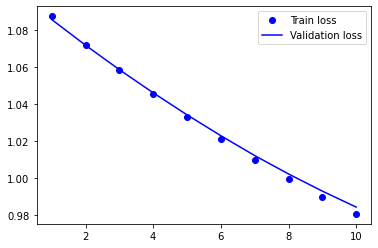

In [19]:
eval_metric(oh_history, 'loss')

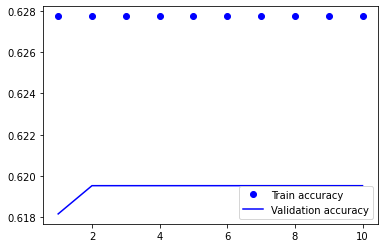

In [20]:
eval_metric(oh_history, 'accuracy')

## Glove embeddings

In [17]:
# #Glove 6B

# !curl -OL http://nlp.stanford.edu/data/glove.6B.zip -o glove.6B.zip
# #wget
# # !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -o glove.6B.zip
# # !unzip -o /content/glove.6B.zip

In [22]:
glove_embeddings = {}
with open('glove.6B.300d.txt') as f:
    glove_embeddings = {l.split()[0]: np.array(l.split()[1:]).astype('float32') for l in f}

In [26]:
airline_words = ['airplane', 'airline', 'flight', 'luggage', 'djfhaskdjfasdf']
for w in airline_words:
    if w in glove_embeddings.keys():
        print('Found the word {} in the dictionary'.format(w))

Found the word airplane in the dictionary
Found the word airline in the dictionary
Found the word flight in the dictionary
Found the word luggage in the dictionary


In [27]:
emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))

for w, i in tk.word_index.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < NB_WORDS:
        vect = glove_embeddings.get(w)
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

In [28]:
glove_model = models.Sequential()
glove_model.add(layers.Embedding(NB_WORDS, GLOVE_DIM, input_length=MAX_LEN))
glove_model.add(layers.Flatten())
glove_model.add(layers.Dense(3, activation='softmax'))
glove_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 24, 300)           3000000   
                                                                 
 flatten_1 (Flatten)         (None, 7200)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 21603     
                                                                 
Total params: 3,021,603
Trainable params: 3,021,603
Non-trainable params: 0
_________________________________________________________________


In [29]:
glove_model.layers[0].set_weights([emb_matrix])
glove_model.layers[0].trainable = False
glove_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 24, 300)           3000000   
                                                                 
 flatten_1 (Flatten)         (None, 7200)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 21603     
                                                                 
Total params: 3,021,603
Trainable params: 21,603
Non-trainable params: 3,000,000
_________________________________________________________________


In [30]:
glove_history = deep_model(glove_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh)
glove_history.history['accuracy'][-1]

Epoch 1/10


2022-07-03 15:29:11.889850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


26/26 - 1s - loss: 0.7768 - accuracy: 0.6700 - val_loss: 0.6978 - val_accuracy: 0.7097 - 892ms/epoch - 34ms/step
Epoch 2/10


2022-07-03 15:29:12.329803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


26/26 - 0s - loss: 0.6359 - accuracy: 0.7466 - val_loss: 0.6452 - val_accuracy: 0.7411 - 317ms/epoch - 12ms/step
Epoch 3/10
26/26 - 0s - loss: 0.5769 - accuracy: 0.7706 - val_loss: 0.6216 - val_accuracy: 0.7445 - 226ms/epoch - 9ms/step
Epoch 4/10
26/26 - 0s - loss: 0.5397 - accuracy: 0.7871 - val_loss: 0.6098 - val_accuracy: 0.7514 - 235ms/epoch - 9ms/step
Epoch 5/10
26/26 - 0s - loss: 0.5132 - accuracy: 0.7990 - val_loss: 0.6026 - val_accuracy: 0.7500 - 233ms/epoch - 9ms/step
Epoch 6/10
26/26 - 0s - loss: 0.4919 - accuracy: 0.8090 - val_loss: 0.6022 - val_accuracy: 0.7493 - 241ms/epoch - 9ms/step
Epoch 7/10
26/26 - 0s - loss: 0.4745 - accuracy: 0.8171 - val_loss: 0.5960 - val_accuracy: 0.7507 - 229ms/epoch - 9ms/step
Epoch 8/10
26/26 - 0s - loss: 0.4607 - accuracy: 0.8229 - val_loss: 0.6002 - val_accuracy: 0.7568 - 243ms/epoch - 9ms/step
Epoch 9/10
26/26 - 0s - loss: 0.4480 - accuracy: 0.8280 - val_loss: 0.6011 - val_accuracy: 0.7480 - 233ms/epoch - 9ms/step
Epoch 10/10
26/26 - 0s - l

0.8316636681556702

In [30]:
glove_results = test_model(glove_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 3)
print('/n')
print('Test accuracy of word glove model: {0:.2f}%'.format(glove_results[1]*100))

46/46 [==============================] - 0s 6ms/step - loss: 0.6600 - accuracy: 0.7466
/n
Test accuracy of word glove model: 74.66%


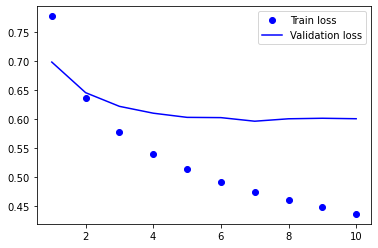

In [31]:
eval_metric(glove_history, 'loss')

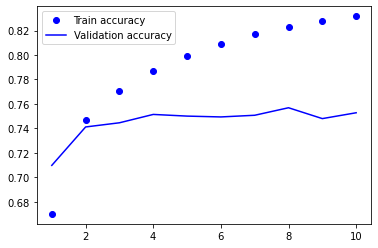

In [32]:
eval_metric(glove_history, 'accuracy')

## Extra section: Trainable Embeddings

In [34]:
emb_model = models.Sequential()
emb_model.add(layers.Embedding(NB_WORDS, 8, input_length=MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(3, activation='softmax'))
emb_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 24, 8)             80000     
                                                                 
 flatten_3 (Flatten)         (None, 192)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 579       
                                                                 
Total params: 80,579
Trainable params: 80,579
Non-trainable params: 0
_________________________________________________________________


In [35]:
emb_history = deep_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh)
emb_history.history['accuracy'][-1]

Epoch 1/10


2022-07-03 15:32:34.340546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


26/26 - 1s - loss: 1.0213 - accuracy: 0.6189 - val_loss: 0.9665 - val_accuracy: 0.6195 - 1s/epoch - 53ms/step
Epoch 2/10


2022-07-03 15:32:35.509926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


26/26 - 1s - loss: 0.9202 - accuracy: 0.6277 - val_loss: 0.9014 - val_accuracy: 0.6195 - 920ms/epoch - 35ms/step
Epoch 3/10
26/26 - 1s - loss: 0.8600 - accuracy: 0.6277 - val_loss: 0.8499 - val_accuracy: 0.6195 - 876ms/epoch - 34ms/step
Epoch 4/10
26/26 - 1s - loss: 0.8066 - accuracy: 0.6313 - val_loss: 0.8009 - val_accuracy: 0.6366 - 850ms/epoch - 33ms/step
Epoch 5/10
26/26 - 1s - loss: 0.7592 - accuracy: 0.6537 - val_loss: 0.7635 - val_accuracy: 0.6516 - 901ms/epoch - 35ms/step
Epoch 6/10
26/26 - 1s - loss: 0.7198 - accuracy: 0.6715 - val_loss: 0.7346 - val_accuracy: 0.6701 - 865ms/epoch - 33ms/step
Epoch 7/10
26/26 - 1s - loss: 0.6836 - accuracy: 0.6916 - val_loss: 0.7083 - val_accuracy: 0.6803 - 896ms/epoch - 34ms/step
Epoch 8/10
26/26 - 1s - loss: 0.6484 - accuracy: 0.7148 - val_loss: 0.6850 - val_accuracy: 0.6940 - 971ms/epoch - 37ms/step
Epoch 9/10
26/26 - 1s - loss: 0.6147 - accuracy: 0.7415 - val_loss: 0.6635 - val_accuracy: 0.7131 - 839ms/epoch - 32ms/step
Epoch 10/10
26/26 -

0.766545295715332

In [54]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 3)
print('/n')
print('Test accuracy of word glove model: {0:.2f}%'.format(emb_results[1]*100))

46/46 [==============================] - 0s 8ms/step - loss: 0.5844 - accuracy: 0.7862
/n
Test accuracy of word glove model: 78.62%


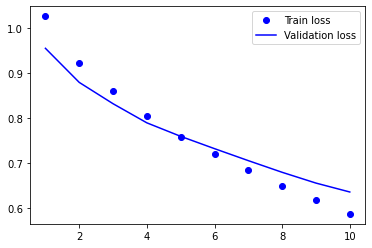

In [55]:
eval_metric(emb_history, 'loss')

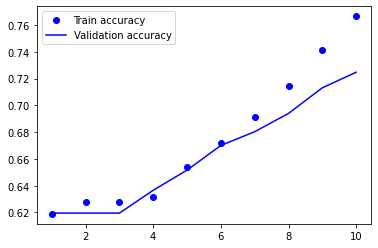

In [36]:
eval_metric(emb_history, 'accuracy')